# Planet: Understanding the Amazon from Space @ [Kaggle](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)
**Use satellite data to track the human footprint in the Amazon rainforest**

[Planet](https://www.planet.com/products/planet-imagery/) is a company with 0.72m, 3m, 5m resolution imagery covering Earth everyday. Making global change visible, accessible and actionable. Planet Analytics Beta Launched July 18, 2018 a product suite that leverages machine learning to transform global, daily satellite imagery into information feeds that detect and classify objects, identify geographic features, and monitor change over time!

### Description
In this competition, Planet and its Brazilian partner SCCON are challenging Kagglers to label satellite image chips with atmospheric conditions and various classes of land cover/land use. Resulting algorithms will help the global community better understand where, how, and why deforestation happens all over the world - and ultimately how to respond.

### Evaluation
Submissions will be evaluated based on their mean (F_{2}) score. The F score, commonly used in information retrieval, measures accuracy using the precision p and recall r. Precision is the ratio of true positives (tp) to all predicted positives (tp + fp). Recall is the ratio of true positives to all actual positives (tp + fn).

There are 17 possible tags: agriculture, artisinal_mine, bare_ground, blooming, blow_down, clear, cloudy, conventional_mine, cultivation, habitation, haze, partly_cloudy, primary, road, selective_logging, slash_burn, water. The file should contain a header and have the following format:
```
image_name,tags
test_0,agriculture road water
test_1,primary clear
test_2,haze primary
etc.
```

### Data
The chips (images) for this competition were derived from Planet's full-frame analytic scene products using our 4-band satellites in sun-synchronous orbit (SSO) and International Space Station (ISS) orbit. 

The imagery has a ground-sample distance (GSD) of 3.7m and an orthorectified pixel size of 3m. The data comes from Planet's Flock 2 satellites in both sun-synchronous and ISS orbits and was collected between January 1, 2016 and February 1, 2017. All of the scenes come from the Amazon basin which includes Brazil, Peru, Uruguay, Colombia, Venezuela, Guyana, Bolivia, and Ecuador.

The chips were labeled using the [Crowd Flower platform](https://www.figure-eight.com/). The commonly prescribed approach for labeling data in the GIS community is to use actual ground truth data to label scenes, which is both costly and time consuming. With this in mind we do believe our data has a reasonably high signal to noise ratio and is sufficient for training.

The labels can broadly be broken into three groups: atmospheric conditions, common land cover/land use phenomena, and rare land cover/land use phenomena. 

### Downloaded data
- train.csv - a list of training file names and their labels, the labels are space-delimited
- sample_submission.csv - correct format of submission, contains all the files in the test set. For more information about the submission file, please go to the Evaluation page
- [train/test]-tif-v2.tar.7z - tif files for the training/test set (updated: May 5th, 2017)
- [train/test]-jpg[-additional].tar.7z - jpg files for the trainin/test set (updated: May 5th, 2017)
- Kaggle-planet-[train/test]-tif.torrent - a BitTorrent file for downloading [train/test]-tif-v2.tar.7z (updated: May 5th, 2017)

# Fastai - Multilabel classification
Use the train.csv and jpg files from the data files. 

### Some really awesome sources of help for this
- [irshadqemu at GitHub](https://github.com/irshadqemu/Kaggle-Competitions/blob/master/Planet_amazon_resnet34.ipynb) and [Blog by Irshad Muhammad](https://towardsdatascience.com/kaggle-planet-competition-how-to-land-in-top-4-a679ff0013ba)
- [Notes by Hiromi Suenaga](https://medium.com/@hiromi_suenaga/deep-learning-2-part-1-lesson-3-74b0ef79e56)
- Kaggle example with EDA recommended by the competition: [Planet: Understanding the Amazon from Space challenge](https://www.kaggle.com/robinkraft/getting-started-with-the-data-now-with-docs)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

#### Import Libraries

In [2]:
import os, sys
#sys.path.append('../')
from fastai.conv_learner import *
from fastai.plots import *
import planet
from planet import f2, opt_th

#### Data path

In [3]:
PATH = os.path.join(os.getcwd() + '/rek-data', 'planet/')
! ls {PATH}
train_csv = f'{PATH}train_v2.csv'

data-store  test-jpg  tmp  train-jpg  train_v2.csv


**Model, batch size and data setup**

In [4]:
bs=64
f_model = resnet34

In [5]:
n = len(list(open(train_csv)))-1
val_idxs = get_cv_idxs(n) # Get random 20% for validation data

In [6]:
def get_data(sz):
    """Returns data generator"""
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', csv_fname=train_csv, tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test-jpg')
# suffix='.jpg' crucial; File names have .jpg at the end, but CSV file does not. 
# So we will set suffix so it knows the full file names.
# by default bs=64

In [7]:
data = get_data(256) # Actual size of the imagery

In [8]:
x,y = next(iter(data.val_dl))
# Dataloader: gives back a transformed mini-batch

Iterating and give me the next batch. PyTorch is pythonic.

In [9]:
y # One mini-batch 64 rows of 17 labels


    1     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     1
    1     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

Notice that there are many 1's and 0's to each row. This is a multi-label classification.

#### Look at one of the images labels, using zip to also view the classes

In [10]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

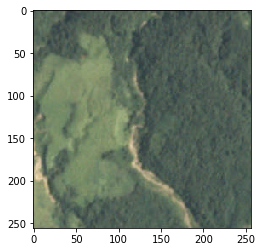

In [11]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

Behind the scenes the fastai library and PyTorch are one-hot encoding.

#### Resize all the imagery to retrain layers from the ImageNet trained ResNet architecture
So the only useful layers from resnet34 architecture are the first few layers that are finding edges/gradients and textures/repeating patterns. So start right back at 64x64 imagery to retrain the model. This is not required if classifying images of dogs vs. cats because the model is near perfect and won't need retrained. 

In [12]:
sz=64 

Resizing any imagery depends on transform, by default resizing will take the smallest edge and resize it (zooms everything out) to 64 then take a centre crop. Using data augmentation means it will take a randomly generated crop. 

In [13]:
data = get_data(sz)

In [14]:
data = data.resize(targ_sz=(int(sz*1.3)), new_path='tmp') # resize is a speed up

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

#### Build model and find out what is the best learning rate

The evaluation criteria of competition is based on f2 score, we define metrics for model accordingly.

f2 simply calls [fbeta_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) from sklearn. You can write any metric you like, as long as it takes two vectors predictions and targets, as numpy arrays and you can return a number...it's a metric!

In [15]:
metrics = [f2]
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.217739   0.349138   0.829453  



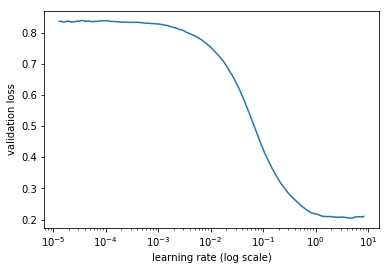

In [16]:
lrf=learn.lr_find()
learn.sched.plot()

Quite a high learning rate because the model is so unlike ImageNet so it needs more training. 

In [17]:
lr = 0.2

#### Train the last layer first
For things that are close to ImageNet, they are really good; for things that are not close to ImageNet, they are better than nothing. All of our fully connected layers, however, are totally random. Therefore, you would always want to make the fully connected weights better than random by training them a bit first. Otherwise if you go straight to unfreeze, then you are actually going to be fiddling around with those early layer weights when the later ones are still random — which is probably not what you want.

By default the fastai will freeze the weights of all of the layers except a few last layers and the ones that it adds to fine-tune the model for given dataset. 


In a CNN initial layers learn to find simple features (like an edge, color gradient, corners) and these features will be equally helpful for for planet data set. So, we are using the lowest LR for them. Higher layers in CNN learns to find complex features (like geometrical patterns, faces, specific objects, etc). An increased value of LR for higher layers would help them to adapt more rapidly to given data set

In [18]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.148423   0.133096   0.882562  
    1      0.140023   0.128225   0.887865                    
    2      0.140817   0.125319   0.89119                     
    3      0.139322   0.124985   0.890336                    
    4      0.134545   0.122539   0.894012                    
    5      0.132556   0.121858   0.89411                     
    6      0.130065   0.12125    0.895391                    



[array([ 0.12125]), 0.895391045211684]

In [20]:
lrs = np.array([lr/9, lr/3, lr]) # Differential learning rates

The early layer, middle layers, final layers learning rates:```[lr/9, lr/3, lr]``` — this is because the images are unlike ImageNet image and earlier layers are probably not as close to what they need to be. If you give an array of 3 elements to fastai, it will divide the layers into 3 sets, initial convolution layers, remaining convolution layers, last fully connected layers.

We will unfreeze the weights of all of the layers to get more accuracy out of our model.

In [23]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.119277   0.108195   0.908754  
    1      0.118786   0.106069   0.908612                    
    2      0.107752   0.10048    0.914996                    
    3      0.112562   0.102881   0.914254                    
    4      0.105676   0.098574   0.916802                    
    5      0.10073    0.096638   0.918401                    
    6      0.098711   0.09628    0.918662                     



[array([ 0.09628]), 0.91866210409214255]

the output of learn.fit is in this format```[ <epoch_number> <train loss> <val loss> <val set f2 score>]```

In [19]:
test = data.train_ds[0]

AttributeError: 'ImageClassifierData' object has no attribute 'train_ds'

In [24]:
learn.save(f'{sz}')

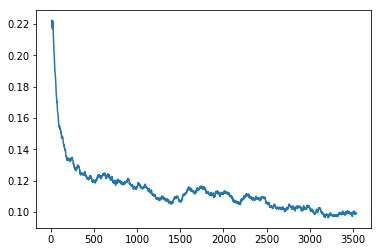

In [25]:
learn.sched.plot_loss()

Double the size of the images, this will repeat a couple of times

In [26]:
sz=128

In [29]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.100684   0.094391   0.919256  
    1      0.098137   0.092823   0.921474                     
    2      0.096665   0.09287    0.920735                     
    3      0.100672   0.092331   0.922796                     
    4      0.095453   0.091705   0.92229                      
    5      0.093245   0.091022   0.923379                     
    6      0.098003   0.090682   0.923515                     



[array([ 0.09068]), 0.92351469377996842]

In [30]:
learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.09364    0.087999   0.926437  
    1      0.096947   0.091114   0.926                        
    2      0.089834   0.085526   0.928787                     
    3      0.099955   0.093191   0.921505                     
    4      0.091071   0.086462   0.929795                     
    5      0.087555   0.084126   0.930362                     
    6      0.085187   0.083636   0.929837                     



In [31]:
sz=256

In [32]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.093642   0.089038   0.925363  
    1      0.092997   0.088585   0.925092                     
    2      0.089865   0.087446   0.926162                     
    3      0.091151   0.088922   0.924691                     
    4      0.091499   0.086941   0.927046                     
    5      0.087727   0.086723   0.92646                      
    6      0.088844   0.086511   0.92694                      



[array([ 0.08651]), 0.92693968937140181]

In [28]:
?? learn.set_data

In [33]:
learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.08861    0.08248    0.932043  
    1      0.091907   0.083637   0.930487                     
    2      0.083607   0.081056   0.93345                      
    3      0.089189   0.085771   0.929547                     
    4      0.089558   0.083263   0.931075                     
    5      0.082645   0.080982   0.933236                     
    6      0.080072   0.080617   0.933539                     



#### Test Time Augmentation (TTA): makes predications on a number of randomly augmented versions of the images.

By applying a simple augmentation on each test image to generate five copies of it and then do the prediction for each copy you can average these prediction to get a significant(1–2%) decrease in error.

In [49]:
probs, y = learn.TTA()

In [50]:
probs = np.mean(probs, axis=0)
f2_tta = f2(probs, y)
print(f2_tta)

0.93228700779


In [51]:
print(probs[0])
print(y[0])

[ 0.66443  0.00093  0.01762  0.00086  0.0005   0.99957  0.00007  0.00036  0.21904  0.02774  0.00043  0.00017
  0.99969  0.36333  0.00495  0.00453  0.83808]
[ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.]


Pick a threshold for our predicts to be included in submission files (0.66 for below example). op_th function tries multiple threshold in a given range and returns the one which maximizes the F2 score

In [52]:
threshold = opt_th(probs, y)
print(threshold)

0.2


In [ ]:
#learn.summary()

Let's now get predictions on the test set rather than the validation set. At this point point we won't get an accuracy because there are no labels for the test set.

In [53]:
test_preds, _ = learn.TTA(is_test=True)

### Making a Submission to Kaggle
In submission file, we need to place predicted labels against each image. It should look like this:

image_name,tags<br>
test_0,agriculture road water<br>
test_1,primary clear<br>
test_2,haze primary<br>
etc.

In [54]:
preds = np.mean(test_preds, axis=0)
classes = np.array(data.classes)

What do the filenames aka image_names look like....

Write code to show results in the competitions submission file structure

In [70]:
data.test_ds.fnames[:4]

['test-jpg/test_25202.jpg',
 'test-jpg/test_5717.jpg',
 'test-jpg/test_40598.jpg',
 'test-jpg/test_35442.jpg']

In [66]:
prediction_results = np.array([" ".join(classes[(np.where(pp>threshold))]) for pp in preds])
filenames = np.array([os.path.basename(fn).split('.')[0] for fn in data.test_ds.fnames])

In [67]:
df_submission = pd.DataFrame(prediction_results, index=filenames, columns=['tags'])
df_submission.head()

,tags
test_25202,agriculture cultivation habitation partly_clou...
test_5717,agriculture clear cultivation habitation prima...
test_40598,agriculture clear primary road water
test_35442,agriculture clear habitation primary road water
test_22859,cloudy haze primary


In [68]:
df_submission.to_csv(f'{PATH}planet_amazon_resnet34_submission.csv', index_label='image_name')